In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt 
import numpy as np  
import lsdb
import pandas as pd
from catalog_filtering import bandFilterLenient, contains_PM

# Global Variables
These will be later implemented into functions

In [4]:
bandList = ['G','R','I','Z','Y']
class_star = 0.95
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
check_invalid_mags = True
crucialCols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
#make issue in lsdb repo, ask to add certifii as a dependency https://github.com/astronomy-commons/lsdb/issues
#i install lsdb, i run this code, i get this error: insert error, when i install certify it works, I am on mac, also add stackoverflow link
# catalog = lsdb.read_hipscat('https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/des/des_dr2/', columns=crucialCols).cone_search(40, -60, 360).to_hipscat('./des_server_test')
catalog = lsdb.read_hipscat('hipscat/des_one_deg/')

# Performing Cross Matching

In the code below, we initially filter the catalog for minimum and maximum values of magnitude measurements to isolate stars with reasonable magnitude measurements. 

From there, we perform a crossmatch on the catalog itself, generating additional columns with stars which are within 18 arcseconds of the specific star. We then compute the dataframe utilizing dask.

In [24]:
#Filtering for specific measurement values
qs = bandFilterLenient(bandList,classStar=class_star,spreadModel=spread_model,magError=magnitude_error,flag=check_flags,invalidMags=check_invalid_mags)
filtered_catalog = catalog.query(qs)

#Performing crossmatch
xmatch = filtered_catalog.crossmatch(filtered_catalog, n_neighbors=100, radius_arcsec=18, suffixes=['_1', '_2'])

with Client():  
    df = xmatch.compute()

df

/Users/johnpassos/Documents/LSDB/venv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,COADD_OBJECT_ID_1,TILENAME_1,HPIX_32_1,HPIX_64_1,HPIX_1024_1,HPIX_4096_1,HPIX_16384_1,RA_1,DEC_1,ALPHAWIN_J2000_1,...,SPREADERR_MODEL_Y_2,WAVG_SPREADERR_MODEL_G_2,WAVG_SPREADERR_MODEL_R_2,WAVG_SPREADERR_MODEL_I_2,WAVG_SPREADERR_MODEL_Z_2,WAVG_SPREADERR_MODEL_Y_2,Norder_2,Dir_2,Npix_2,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10369036480038305792,1346141080,b'DES0253-0458',9209,36838,9430583,150889339,2414229437,42.958301,-4.877688,42.958301,...,0.007929,-99.0,0.002601,0.001679,0.001619,-99.0,5,0,9209,0.0
10369036678043009024,1346140288,b'DES0253-0458',9209,36838,9430583,150889342,2414229483,42.962892,-4.870471,42.962892,...,0.000889,-99.0,-99.0,0.000344,0.000265,0.001429,5,0,9209,0.0
10369036678043009024,1346140288,b'DES0253-0458',9209,36838,9430583,150889342,2414229483,42.962892,-4.870471,42.962892,...,0.000149,0.000112,0.00005,0.000043,0.000046,0.000174,5,0,9209,2.361605
10369036678261112832,1346139897,b'DES0253-0458',9209,36838,9430583,150889342,2414229483,42.962541,-4.869916,42.962541,...,0.000149,0.000112,0.00005,0.000043,0.000046,0.000174,5,0,9209,0.0
10369036678261112832,1346139897,b'DES0253-0458',9209,36838,9430583,150889342,2414229483,42.962541,-4.869916,42.962541,...,0.000889,-99.0,-99.0,0.000344,0.000265,0.001429,5,0,9209,2.361605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10374613634851536896,1342656156,b'DES0251-0250',9214,36858,9435656,150970498,2415527970,42.790451,-2.897533,42.790451,...,0.000295,0.000378,0.000139,0.000082,0.00008,0.0003,4,0,2303,0.0
10374613652320813056,1342655803,b'DES0251-0250',9214,36858,9435656,150970498,2415527974,42.796759,-2.892249,42.796759,...,0.008548,0.002334,0.00205,0.001899,0.003342,-99.0,4,0,2303,0.0
10374613652320813056,1342655803,b'DES0251-0250',9214,36858,9435656,150970498,2415527974,42.796759,-2.892249,42.796759,...,0.000663,0.000377,0.000168,0.000128,0.000178,0.000659,4,0,2303,5.93719


Text(0.5, 1.0, 'Distance between Stars in Arcseconds')

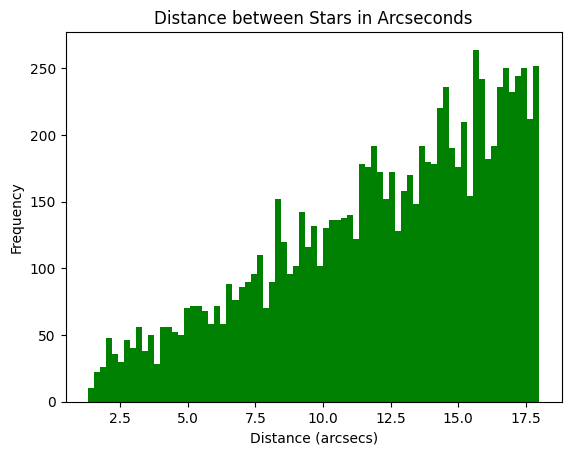

In [15]:
mask = df['_dist_arcsec'] > 0
no_doubles_dist = df['_dist_arcsec'][mask]


plt.hist(no_doubles_dist, bins = 75, color = 'green')
plt.xlabel('Distance (arcsecs)')
plt.ylabel('Frequency')
plt.title('Distance between Stars in Arcseconds')

# Finding Amount of Matches Per Star

This is an important step in filtering as it is likely that PM stars will appear at least 4 times in the current catalog. As seen below, there are not many stars with 4 or more matches, so there will not be many possible false PM star groups to filter out.

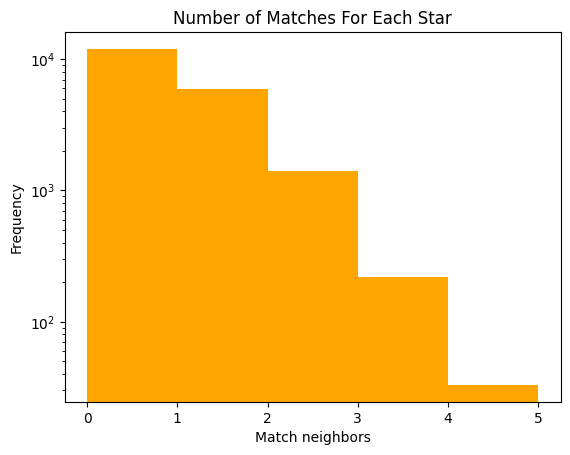

In [16]:
neighbors = df.groupby('_hipscat_index')['_dist_arcsec'].count()
neighbors -= 1 #Double counting adjustment

plt.hist(neighbors, color = 'orange', bins= [i for i in range(0,6)])
plt.xlabel('Match neighbors')
plt.ylabel('Frequency')
plt.title('Number of Matches For Each Star')
plt.yscale('log')

# Graphing Groups of Stars Larger than 4

To begin performing calculations to predict wether or not a star group is a PM star, this code graphs our star groups to form a better understanding of how to perform that calculation.

First, we must filter our dataframe for only large star groups (4 or more). Then, we group said dataframe by the hipscat index of one of the stars. We then collect the RA and DEC of the stars in each group, and scatter these on a plot if the RA of our primary star is equivalent to the minimum RA of all the stars in the group. This step is important because it ensures that we do not graph the same system more than once.

Text(0.5, 1.0, 'Star Groups Graphed by Displacement from Reference Star')

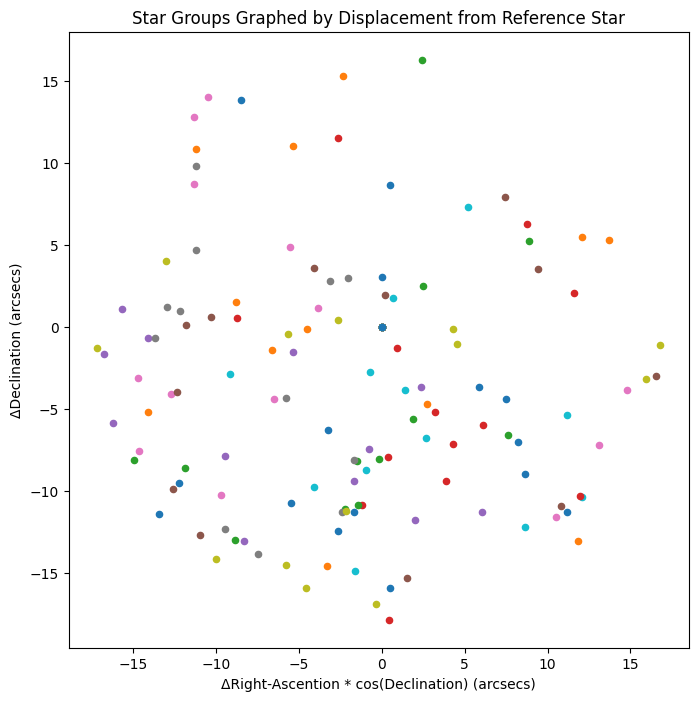

In [17]:
#DO GROUPBY IN DASK catalog.__ddf__
df['neighbors'] = neighbors

three_or_more_matches = df.query('neighbors >= 3')
star_groups = three_or_more_matches.groupby('_hipscat_index')

plt.figure(figsize=(8, 8))
#Loop through groups of matched stars
for _hipscat_index, group in star_groups:
    #origin point
    ra1, dec1 = group.iloc[0][["RA_1", "DEC_1"]]
    
    #array of matched points
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T

    #perform delta RA, DEC calculations
    x = (ra2 - ra1) * np.cos(np.radians(dec1)) * 3600
    y = (dec2 - dec1) * 3600

    id_1 = group.iloc[0]['COADD_OBJECT_ID_1']
    id_2 = group['COADD_OBJECT_ID_2'].to_numpy().T

    if (id_1 == min(id_2)):
        plt.scatter(x, y, s=20)

#DO GROUPBY IN DASK catalog.__ddf__
plt.xlabel('ΔRight-Ascention * cos(Declination) (arcsecs)')
plt.ylabel('ΔDeclination (arcsecs)')
plt.title('Star Groups Graphed by Displacement from Reference Star')

# PM Star Calculations:

Assume that we can use right-ascention and declination values as x and y values in a cartesian coordinate system.
$\newline$

Suppose you have a line with direction vector $v = <x,y>$ that intersects $Q = (0,0)$, and you are trying to find its distance from the point $P = (p_x,p_y)$. We can create a vector from the line to the point by doing:

$P - Q = <p_x,p_y> = \overrightarrow{PQ}$

Now, it is known that the magnitude of the cross-product of two vectors is equivalent to the area of the parallelogram created by said vectors, which is also equivalent to the base times the height of the parallelogram. The distance in this case is the height while the base is the line vector $v$. This leaves:

$|\overrightarrow{PQ} \times v| = |v|d$

Now solving for $d$:

$d = \frac{|\overrightarrow{PQ} \times v|}{|v|}$

We know that $Q$ is simply the origin, so we can simplify this by making $\overrightarrow{PQ}$ to simply $<p_x,p_y>$:

$d = \frac{|<p_x,p_y>\times v|}{|v|}$

It is fair to always assume that the origin will be a point on the line because we are graphing groups in reference to one of the stars part of that group. This means we are subtracting the coordinates of every star by one of the stars. Eventually the reference star will subtract from itself, leaving the point (0,0). From there, we create a line with a direction vector from the reference star to one of the other stars, minimizing the amount of lines we have to project to check if the star group is one PM star.

These calculations were made with help from: https://openstax.org/books/calculus-volume-3/pages/2-5-equations-of-lines-and-planes-in-space

In [11]:
def distance_to_line(PQ, line_vector):
    return np.abs(np.cross(PQ, line_vector)) / np.linalg.norm(line_vector)

def closeToProjection(line_vector, x, y, error):
    PQ = np.array([x, y])
    distance = distance_to_line(PQ, line_vector)
    return distance < error

Text(0.5, 1.0, 'Possible PM Stars Following Star Filtering and Line Projection')

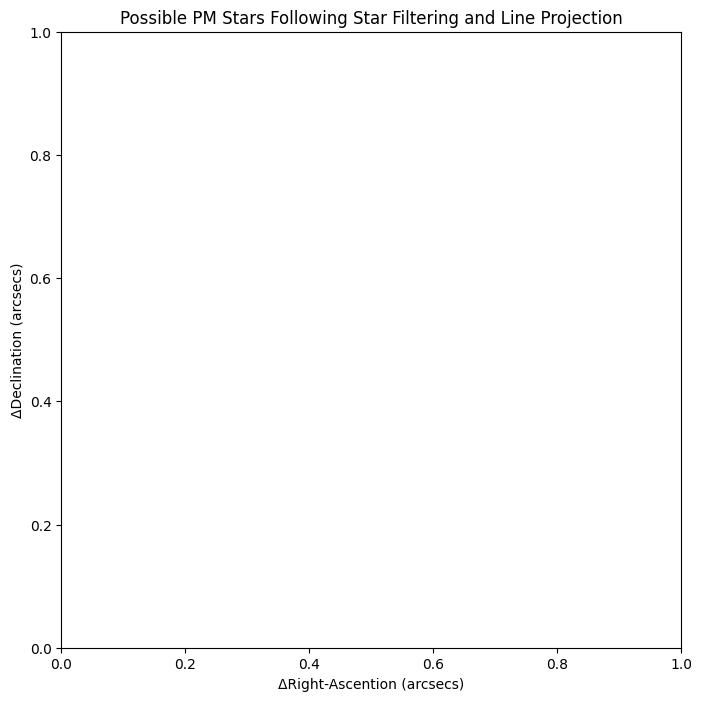

In [12]:

PM_df = pd.DataFrame()

plt.figure(figsize=(8, 8))
for _hipscat_index, group in three_or_more_matches.groupby('_hipscat_index'):
    #origin point
    ra1, dec1 = group.iloc[0][["RA_1", "DEC_1"]]
    
    #array of matched points
    ra2, dec2 = group[["RA_2", "DEC_2"]].to_numpy().T

    #perform delta RA, DEC calculations
    x_vals = (ra2 - ra1) * np.cos(np.radians(dec1)) * 3600
    y_vals = (dec2 - dec1) * 3600

    #Create list of tuples of coordinates
    coords = zip(x_vals, y_vals)
    coords = list(coords)

    id_1 = group.iloc[0]['COADD_OBJECT_ID_1']
    id_2 = group['COADD_OBJECT_ID_2'].to_numpy().T


    for i in range(len(coords)):
        found = 0
        line_vector = coords[i]

        if (line_vector == (0,0)): continue #invalid line vector
        
        for j in range(len(coords)):
            if (j == i): continue #prevent double counting

            test_x, test_y = coords[j]
            if closeToProjection(line_vector, test_x, test_y, .2): #2 milliseconds
                found += 1

        if (found >= 3) and (id_1 == min(id_2)): #4 or more in a line (probable PMS) and prevent double graphing
            plt.scatter(x_vals, y_vals, s=20)
            PM_df = pd.concat([PM_df, group], axis=0)

plt.xlabel('ΔRight-Ascention (arcsecs)')
plt.ylabel('ΔDeclination (arcsecs)')
plt.title('Possible PM Stars Following Star Filtering and Line Projection')


#use object ID instead of ra for double counting prevention

In [7]:
small_scope = filtered_catalog.cone_search(42.817451981441494, -3.8882601693023133, 20)

small_df = small_scope.compute()

small_df

,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,FLAGS_G,FLAGS_R,FLAGS_I,FLAGS_Z,FLAGS_Y,...,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10370986798804369408,0.005172,0.982307,0.9952,0.994617,0.99233,3,3,3,3,3,...,22.706379,19.362398,17.116657,15.483732,14.955669,0.05949,0.003771,0.001143,0.0008,0.001202
10370986798997307392,0.363681,0.980886,0.990194,0.132001,0.976497,3,3,3,3,3,...,22.605766,19.425049,17.086205,-99.0,14.967874,0.044888,0.004398,0.001177,-99.0,0.001725
10370986891217469440,0.478828,0.895304,0.977812,0.984843,0.983378,3,3,3,3,3,...,-99.0,-99.0,-99.0,15.489192,-99.0,-99.0,-99.0,-99.0,0.001013,-99.0
10370986892068913152,0.19909,0.980313,0.985622,0.028624,0.98472,3,3,3,3,3,...,22.595758,19.385511,17.113192,-99.0,14.974467,0.044052,0.004155,0.000972,-99.0,0.000905


Text(0.5, 1.0, 'Known PM Star with Hipscat Indecies')

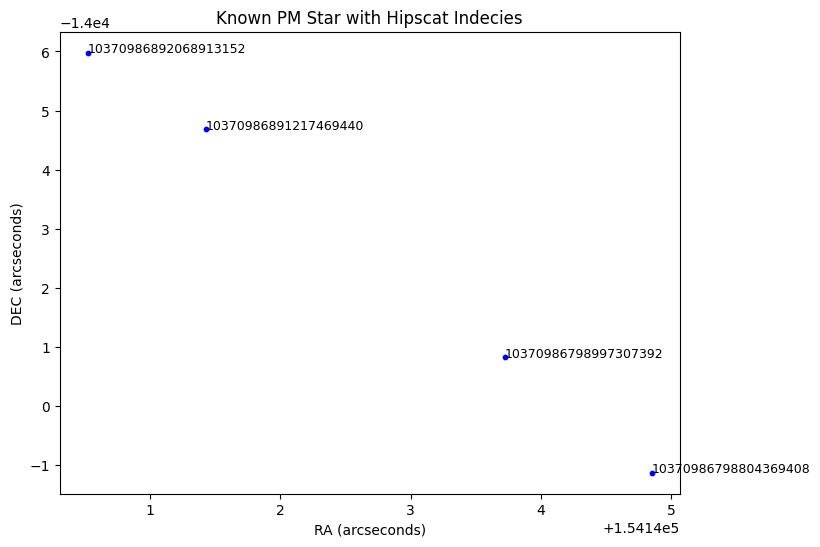

In [8]:
x_vals = (ra2 - ra1) * np.cos(np.radians(dec1)) * 3600
y_vals = (dec2 - dec1) * 3600

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(small_df['RA'] * 3600, small_df['DEC'] * 3600, s=10, color='blue')

# Annotate each point with the hipscat index
for i, row in small_df.iterrows():
    plt.text(row['RA'] * 3600, row['DEC'] * 3600, str(i), fontsize=9)

# Add labels and title
plt.xlabel('RA (arcseconds)')
plt.ylabel('DEC (arcseconds)')
plt.title('Known PM Star with Hipscat Indecies')